In [ ]:
import jax
import copy
import jax.numpy as jnp
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
import matplotlib
import seaborn as sns
from copy import deepcopy
from google.colab import files
from sklearn.datasets import load_breast_cancer
%config InlineBackend.figure_formats = ['svg']

## Get Toy Classification data

In [ ]:
def get_data(n_samples=1000, n_features=100, noise_level=0.3, margin=1.0):
    X_class0 = np.random.randn(n_samples // 2, n_features) - margin
    X_class1 = np.random.randn(n_samples // 2, n_features) + margin
    X = np.vstack([X_class0, X_class1])
    noise = noise_level * np.random.randn(n_samples, n_features)
    X += noise
    y = np.hstack([np.zeros(n_samples // 2), np.ones(n_samples // 2)])
    indices = np.random.permutation(n_samples)
    X, y = X[indices], y[indices]
    return X, y

def flip_labels(y,p):
  random_values = np.random.rand(y.shape[0])
  flip_mask = random_values <= p
  return np.where(flip_mask, 1 - y, y)

N = 100
d = 100
delta = 0.01
X,y = get_data(N,d)
#X, y = load_breast_cancer(return_X_y=True) # true dataset, not tested here
#N = np.shape(X)[0]
#d = np.shape(X)[1]

## Loss function

In [ ]:
def loss(ww, XX, yy):
    logits = ww @ XX.T
    preds = jax.nn.sigmoid(logits)
    epsilon = 1e-6
    preds = jnp.clip(preds, epsilon, 1.0 - epsilon)
    loss = -jnp.mean(yy * jnp.log(preds) + (1 - yy) * jnp.log(1 - preds))+ 0.5 * delta * jnp.linalg.norm(ww)**2
    return loss
grad = jax.jit(jax.grad(loss, argnums=(0,)))
hess = jax.jit(jax.hessian(loss, argnums=(0,)))

def acc(ww, XX, yy):
    logits = ww @ XX.T
    preds = jax.nn.sigmoid(logits)
    epsilon = 1e-6
    preds = jnp.clip(preds, epsilon, 1.0 - epsilon)
    predicted_labels = (preds >= 0.5).astype(int)
    accuracy = jnp.mean(predicted_labels == yy)
    return accuracy

## Training

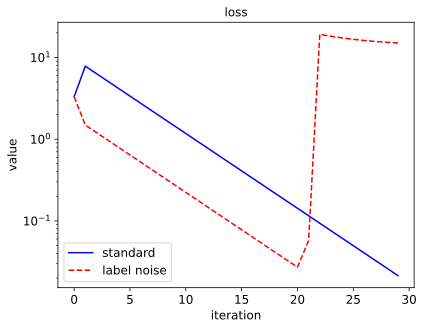

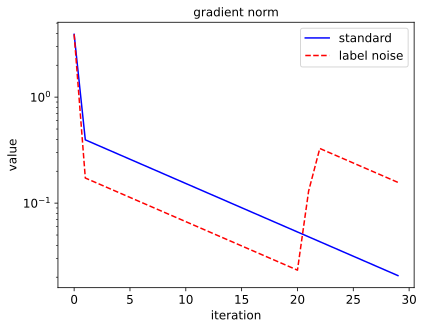

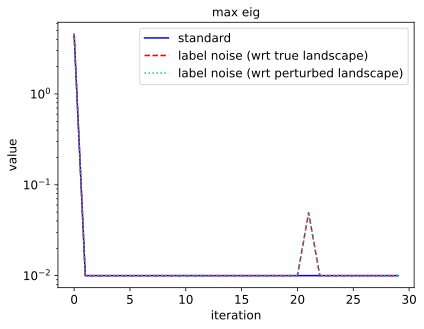

In [ ]:
p = 0.33
nit = 30
fig1 = plt.figure()
fig2 = plt.figure()
fig3 = plt.figure()


w0 = jnp.array(np.random.normal(size=(d,)))
etas = [10] #big lr for big fun
for lr in etas:
  w = copy.deepcopy(w0)
  loss_hist = []
  grad_hist = []
  hess_hist = []
  acc_hist = []
  for it in range(nit):
      grad_hist.append(np.linalg.norm(grad(w,X,y)))
      H=hess(w,X,y)[0][0]
      eH=np.linalg.eigh(H)[0]
      hess_hist.append(np.max(eH))
      loss_hist.append(loss(w,X,y))
      acc_hist.append(acc(w,X,y))
      w = w-lr*grad(w,X,y)[0]
  plt.figure(fig1)
  plt.plot(loss_hist,color='b',label='standard')
  plt.figure(fig2)
  plt.plot(grad_hist,color='b',label='standard')
  plt.figure(fig3)
  plt.plot(hess_hist,color='b',label='standard')


for lr in etas:
  w = copy.deepcopy(w0)
  loss_hist = []
  grad_hist = []
  hess_hist = []
  hess_noise_hist = []
  acc_hist = []
  for it in range(nit):
      grad_hist.append(np.linalg.norm(grad(w,X,y)))
      H=hess(w,X,y)[0][0]
      eH=np.linalg.eigh(H)[0]
      hess_hist.append(np.max(eH))
      loss_hist.append(loss(w,X,y))
      acc_hist.append(acc(w,X,y))
      hat_y = flip_labels(y,p)
      H=hess(w,X,hat_y)[0][0]
      eH=np.linalg.eigh(H)[0]
      hess_noise_hist.append(np.max(eH))
      w = w-lr*grad(w,X,hat_y)[0]
  plt.figure(fig1)
  plt.plot(loss_hist,'--',color='r',label='label noise')
  plt.figure(fig2)
  plt.plot(grad_hist,'--',color='r',label='label noise')
  plt.figure(fig3)
  plt.plot(hess_hist,'--',color='r',label='label noise (wrt true landscape)')
  plt.plot(hess_noise_hist,linestyle='dotted',color='c',label='label noise (wrt perturbed landscape)')

plt.figure(fig1)
plt.title('loss',fontsize=12)
plt.xlabel('iteration',fontsize=12)
plt.ylabel('value',fontsize=12)
plt.yscale('log')
plt.legend(fontsize=12)
plt.figure(fig2)
plt.title('gradient norm',fontsize=12)
plt.xlabel('iteration',fontsize=12)
plt.ylabel('value',fontsize=12)
plt.yscale('log')
plt.legend(fontsize=12)
plt.figure(fig3)
plt.title('max eig',fontsize=12)
plt.xlabel('iteration',fontsize=12)
plt.ylabel('value',fontsize=12)
plt.yscale('log')
plt.legend(fontsize=12)
#plt.ylim([1e-4, 5])


## Theory : precise proof that a boost can happen.

Note that doing theory for logistic regression is difficult. Me and Cathy just had a paper about new results there https://arxiv.org/abs/2406.05033 . It is exponentially more difficult than linear regression.


Let's then try to get some insights from linear regression instead. We are still doing classification, just with L2 loss. Consider the perturbed loss

$$L(w)=\|Xw - y -\epsilon\|_2^2$$

the gradient of this is

$$\nabla L(w) = X^\top(Xw - y -\epsilon) = (X^\top X)w + -X^\top y- X^\top \epsilon$$

Setting the gradient to 0 (for $\epsilon=0$), we also get the problem solution. The solution is the one for the unperturbed problem, of course.

$$w^* = (X^\top X)^{-1}X^\top y$$

How much the gradient points to the solution is captured by this standard optimization metric

$$c = \langle \nabla L(w), w-w^*\rangle = \langle (X^\top X)w - X^\top y-X^\top \epsilon, w-(X^\top X)^{-1}X^\top y\rangle.$$

The bigger this quantity is, the more we are ''pointing'' to the solution. We get

$$c = c_0 - \epsilon^\top X w + \epsilon^\top X(X^\top X)^{-1}X^\top y.$$

where $c_0$ is the value of $c$ in the noiseless setting.

It is now crucial to use the hypothesis: we are at initialization, $w$ is random and gaussian distributed. In expectation, the second term drops and we get

$$\mathbb{E}_{init}[c] = \mathbb{E}_{init}[c_0] + \epsilon^\top X(X^\top X)^{-1}X^\top y.$$


**So in particular we get a boost in "pointing to the right direction" at initialization if label noise is positively correlated with the label.**

## Theory 2: what actually matters

We now do something more general. Consider updating parameters with

$$w^+ = w-\eta d,$$

where d is some direction. We expand the loss

$$L(w^+) = L(w-\eta d) \simeq L(w) - \eta \langle \nabla L(w), d\rangle + \frac{1}{2}\eta^2 d^\top \nabla^2 L(w) d.$$

This shows that prograss in the loss is given by
$$progress = \eta \langle \nabla L(w), d\rangle - \frac{1}{2}\eta^2 d^\top \nabla^2 L(w) d.$$

We expect this quantity to be bigger for $d$ being the perturbed gradient. In particular, note that in the above the first step for the unperturbed vartiant is actually taking the loss up. We therefore expect the progress to be negative for the unperturbed variant and positive for the perturbed variant.

problem solution found


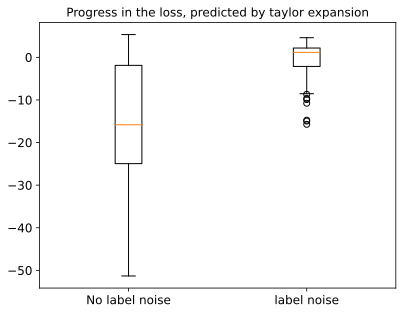

In [ ]:
# get problem solution with GD
w_star = copy.deepcopy(w0)
for it in range(10000):
    w_star = w_star-10*grad(w_star,X,y)[0]
    if np.linalg.norm(grad(w_star,X,y))<1e-4:
      print('problem solution found')
      break

cs=[]
cs_noise=[]
lr = 1
for e in range(100):
  w = np.random.normal(size=(d,))
  H=hess(w,X,y)[0][0]
  g =grad(w,X,y)[0]
  hat_y = flip_labels(y,0.3)
  hat_g = grad(w,X,hat_y)[0]
  cs.append(lr*(w-w_star).T@g-0.5*(lr**2)*g.T@H@g)
  cs_noise.append(lr*(w-w_star).T@hat_g-0.5*(lr**2)*hat_g.T@H@hat_g)

plt.boxplot([cs, cs_noise],labels=['No label noise', 'label noise'])
plt.title('Progress in the loss, predicted by taylor expansion')
plt.show()
